# v7

In [1]:
import numpy as np

PI=Pi=np.pi
Abs=np.abs
Log=np.log
Sqrt=np.sqrt
Exp=np.exp
Cos=np.cos
def SqrtClip(x):
    return np.sqrt(np.clip(x,0,None))
    

In [2]:
np.clip([-2.0,4.3,-3.2,10],0,None)

SqrtClip([-2.0,4.3,-3.2,10])

array([ 0.        ,  2.07364414,  0.        ,  3.16227766])

## I3

In [3]:

    
class I3():
    ''' This module numerically integrates F according to Eq.(xxx) using the Monte-Carlo method. 
        phase space: 1->2 
        To use it, you need to set n, F, m123, Tqx, and invoke the generate() function to 
        generate n samples, then run the go() function to obtain the final result
    '''
    def __init__(self):
        self.Tqx=10.0
        self.n=1000
        self.variables=[
                ("xq",0,1),
                ("cq",-1,1),("c2bar",-1,1),
                ("phiq",0,2*Pi),("phi2bar",0,2*Pi)]
        self.var_rand={}
        self.V=1.0
        self.F=None
        self.m123=(0,0,0)
        self.Theta=None
        self.f_result=None
    def generate(self):
        V=1.0
        for entry in self.variables:
            self.var_rand[entry[0]]=np.random.uniform(entry[1],entry[2],self.n)
            V=V*(entry[2]-entry[1])
        self.V=V
        
   
    def go(self):
        m1,m2,m3=self.m123
        F=self.F
        Tqx=self.Tqx
        
#         global Theta,s,E,q,Q2,q2,qc,qc2,En,En2 # debug

        xq=self.var_rand["xq"]
        c2=self.var_rand["c2bar"]
        q=-Tqx*Log(xq)

        Eq=Sqrt(m1**2 + q**2)

        EE=Eq**2
        qq=q**2 # I could use q2, but since there are p2,p3,E2....this would be confusing       
        QQ=EE - qq        # QQ is defined as q.q=Eq^2-q^2,
        qc=q*c2 #q*cos(theta_2_bar)   
        qcqc=qc**2      
        
        Delta=m2**4 + (m3**2-QQ)**2-2*m2**2*(m3**2 + QQ + 2*(qq - qcqc))
        Theta=np.heaviside(QQ,(m2+m3)**2) * np.heaviside(Delta,0)
        
        

         
        #compute E2,p2,E3,p3

        
        p2=((m2**2 - m3**2 + QQ)*qc + Eq*SqrtClip(Delta))/(2.*(EE - qcqc))
        p2p2=p2**2
        E2=Sqrt(m2**2 + p2p2)
        E3=Eq-E2
        p3=SqrtClip(E3**2-m3**2)
        
        
        dotq2=Eq*E2-qc*p2
        dot12=dotq2
        
        
        dpdx=(Tqx)/(xq)
        E1=Eq
        F_val=F(E1,E2,dot12)
        #note that p1**2 has been -> q**2 
        f_result= qq/((2*Pi)**3*2.*E1)*\
                  p2p2/((2*Pi)**3*2.*E2)*\
                  (2*Pi)/(2.*E3)*F_val*dpdx/Abs(p2/E2 + (p2 - qc)/E3)  *Theta
        
        self.f_result=f_result
        self.Theta=Theta

        
        f_mean=np.mean(f_result)
        return f_mean*self.V

    

In [31]:
        
#         nonzero_indices=np.nonzero(Theta)
#         f_result_physical=np.take(f_result,nonzero_indices) #select only physical samples

### test some samples

In [32]:
from time import time
start_time=time()

m1,m2,m3=1.,0,0
T1=1.0

def F_MB(E1,E2,dot12):
    return E2*Exp(-E1/T1)

np.random.seed(1)

result=[]
for i in range(10):
    iii=I3()
    iii.Tqx=4*T1
    iii.m123=(m1,m2,m3)
    iii.n=10000000
    iii.F=F_MB
    iii.generate()
    result.append(iii.go())
#     print ("MB result=",result[i])

print ((time()-start_time))
print (result)

from scipy.special import kv as besselK
print ("Bessel result (MB, m2=m3=0):", m1**2 * T1 * besselK(2,m1/T1)/(64*PI**3) )

35.35977077484131
[0.00081956861491810755, 0.00081972969567508606, 0.00082026143498897873, 0.0008190327321802829, 0.00081635702516868656, 0.00081742316081080354, 0.00081858219631326457, 0.0008175918803631139, 0.00081946796330825895, 0.00081845222766891823]
Bessel result (MB, m2=m3=0): 0.000818805432621


In [55]:
np.round(np.array(result)*1e4,3)

array([ 8.196,  8.197,  8.203,  8.19 ,  8.164,  8.174,  8.186,  8.176,
        8.195,  8.185])

In [4]:
# m1,m2,m3=1.,0,0
m1,m2,m3=1.,0.1,0.1
T1=1.0

def F_MB(E1,E2,dot12):
    return E2*Exp(-E1/T1)

def F(E1,E2,dot12):
    E3=E1+E2
    fnuL=1.0/(Exp(E3/T1)+1)
    fh=1.0/(Exp(E1/T1)-1)
    fnuR=0
    return E2*fh*(1-fnuL)*(1-fnuR)

iii=I3()
iii.Tqx=4*T1
iii.m123=(m1,m2,m3)
iii.n=1000000
iii.F=F_MB
iii.generate()
print ("MB result=", iii.go())

iii.F=F
iii.generate()
print ("result=", iii.go())


from scipy.special import kv as besselK
print ("Bessel result (MB, m2=m3=0):", m1**2 * T1 * besselK(2,m1/T1)/(64*PI**3) )

MB result= 0.000799615624639
result= 0.000849099251229
Bessel result (MB, m2=m3=0): 0.000818805432621


## compute $C_{\nu_R}/|{\cal M}|^2$ of decay processes: cases (I-1), (I-2), (II-1),(III-1)

In [5]:
def F_I_1(E1,E2,dot12):
    # B >>>> nuR+F
    global T1
    f1=1.0/(Exp(E1/T1)-1) #BE statistics
    f2=0 #nuR
    E3=E1-E2
    f3=1.0/(Exp(E3/T1)+1) #FD statistics
    return E2*f1*(1-f2)*(1-f3) #BE, FD, FD statistics

def F_I_2(E1,E2,dot12):    
    # F >>>> nuR+B
    global T1
    f1=1.0/(Exp(E1/T1)+1) #FD statistics
    f2=0 #nuR
    E3=E1-E2
    f3=1.0/(Exp(E3/T1)-1) #BE statistics
    return E2*f1*(1-f2)*(1+f3) #FD, FD, BE statistics

def F_II_1(E1,E2,dot12):
    # B >>>> nuR+F
    global T1
    f1=1.0/(Exp(E1/T1)-1) #BE statistics
    f2=0 #nuR
    f3=0 #F not in thermal equilibrium
    return E2*f1*(1-f2)*(1-f3) #BE, FD, FD statistics

def F_III_1(E1,E2,dot12):
    # F >>>> nuR+B
    global T1
    f1=1.0/(Exp(E1/T1)+1) #FD statistics
    f2=0 #nuR
    f3=0 #B not in thermal equilibrium
    return E2*f1*(1-f2)*(1+f3) #FD, FD, BE statistics

In [6]:
MeV=1.0;
GeV=1e3*MeV;
TeV=1e3*GeV

In [7]:
from time import time
start_time=time()

m1list=np.array([1*TeV,1*GeV,100*MeV])
m2list=0*m1list
m3list=m1list/2
resultsss=[]
for im1,m1 in enumerate(m1list):
    resultss=[]
    for iF,F in enumerate([F_I_1,F_I_2,F_II_1,F_III_1]):
        m2=m2list[im1]
        m3=m3list[im1]

        iii=I3()
        # iii.Tqx=4*T1
        iii.m123=(m1,m2,m3)
        iii.n=1000000
        iii.F=F
        # iii.generate()

        T1list=m1 * np.logspace(-2,1,40)
        results=[]

        for i,T1 in enumerate(T1list):
            print ("\r m1=",m1,"F=",iF,"i=",i,"/",len(T1list),end=",")    
            iii.Tqx=4*T1
            iii.generate()
            results.append(iii.go())

        resultss.append(np.array([T1list,results]))
    resultsss.append(resultss)
    
print ("time used=",time()-start_time)
    

 m1= 100.0 F= 3 i= 39 / 40,,40,time used= 164.78315234184265


In [11]:
np.save("data/C_decay.npy",[resultsss,m1list,m2list,m3list])

In [8]:
from time import time
start_time=time()

m1list=np.array([1*TeV,1*GeV,100*MeV])
m2list=0*m1list
m3list=0*m1list
resultsss=[]
for im1,m1 in enumerate(m1list):
    resultss=[]
    for iF,F in enumerate([F_I_1,F_I_2,F_II_1,F_III_1]):
        m2=m2list[im1]
        m3=m3list[im1]

        iii=I3()
        # iii.Tqx=4*T1
        iii.m123=(m1,m2,m3)
        iii.n=1000000
        iii.F=F
        # iii.generate()

        T1list=m1 * np.logspace(-2,1,40)
        results=[]

        for i,T1 in enumerate(T1list):
            print ("\r m1=",m1,"F=",iF,"i=",i,"/",len(T1list),end=",")    
            iii.Tqx=4*T1
            iii.generate()
            results.append(iii.go())

        resultss.append(np.array([T1list,results]))
    resultsss.append(resultss)
    
print ("time used=",time()-start_time)

np.save("data/C_decay_0mfinal.npy",[resultsss,m1list,m2list,m3list])
    

 m1= 100.0 F= 3 i= 39 / 40,,40,time used= 163.57228755950928


## I4

In [3]:
class I4():
    ''' This module numerically integrates F according to Eq.(xxx) using the Monte-Carlo method. 
        phase space: 2->2 
        To use it, you need to set n, F, m1234, Tqx, T2x, and invoke the generate() function to 
        generate n samples, then run the go() function to obtain the final result
    '''
    def __init__(self):
        self.Tqx=10.0
        self.T2x=10.0
        self.n=1000
        self.variables=[("xq",0,1),("x2",0,1),
                ("cq",-1,1),("c2",-1,1),("c3",-1,1),
                ("phi1",0,2*Pi),("phi2",0,2*Pi),("phi3",0,2*Pi)]
        self.var_rand={}
        self.V=1.0
        self.F=None
        self.m1234=(0,0,0,0)
    def generate(self):
        V=1.0
        for entry in self.variables:
            self.var_rand[entry[0]]=np.random.uniform(entry[1],entry[2],self.n)
            V=V*(entry[2]-entry[1])
        self.V=V
        
   
    def go(self):
        m1,m2,m3,m4=self.m1234
        F=self.F
        Tqx=self.Tqx
        T2x=self.T2x

        xq=self.var_rand["xq"]
        x2=self.var_rand["x2"]
        c2=self.var_rand["c2"] #now c2 is defined as the angle btw. q and p2
        c3=self.var_rand["c3"]
        q=-Tqx*Log(xq)        
        p2=-T2x*Log(x2)
        p1=Sqrt(q**2 - 2*c2*q*p2 + p2**2) # derived from p1_vec=q_vec-p2_vec
        E1=Sqrt(m1**2 + p1**2)
        E2=Sqrt(m2**2 + p2**2)
        Eq=E1+E2
        EE=Eq**2
        qq=q**2 # I could use q2, but since there are p2,p3,E2....this would be confusing 
        QQ=EE - qq        # QQ is defined as q.q=Eq^2-q^2,
        Theta=np.heaviside(QQ,(m3+m4)**2)   
     
        
        qc=q*c3 #q*cos(theta_2_bar)   
        qcqc=qc**2      
        
        Delta=m3**4 + (m4**2-QQ)**2-2*m3**2*(m4**2 + QQ + 2*(qq - qcqc))
        Theta=np.heaviside(QQ,(m3+m4)**2) * np.heaviside(Delta,0)
         

            
            
        #from q, compute E3,p3,E4,p4
        p3= ((m3**2 - m4**2 + QQ)*qc + Eq*SqrtClip(Delta))/(2.*(EE - qcqc))
        E3=Sqrt(m3**2 + p3**2)
        E4=Eq-E3
        p4=SqrtClip(E4**2 -m4**4)

        
        
        
        dotq2=Eq*E2-q*p2*c2
        dotq3=Eq*E3-q*p3*c3

        s2=Sqrt(1-c2**2)
        s3=Sqrt(1-c3**2)
        phi2=self.var_rand["phi2"]
        phi3=self.var_rand["phi3"]
        dot23=E2*E3-p2*p3*(s2*s3*Cos(phi2-phi3)+c2*c3)

        dot13=dotq3-dot23 #p1.p3=(q-p2).p3
        dot12=dotq2-m2**2 #p1.p2=(q-p2).p2
        
        
        dpdx=(Tqx*T2x)/(xq*x2)
        F_val=F(E1,E2,E3,dot12,dot13,dot23)
        #note that p1**2 has been -> q**2 according to 2020.08.15.2
        f_result= q**2/((2*Pi)**3*2.*E1)*\
                  p2**2/((2*Pi)**3*2.*E2)*\
                  p3**2/((2*Pi)**3*2.*E3)*\
                  (2*Pi)/(2.*E4)*F_val*Theta*dpdx/Abs(p3/E3 + (p3 - q*c3)/E4)
        f_mean=np.mean(f_result)
        return f_mean*self.V
    


### test some samples

In [4]:
mX=10
m1,m2,m3,m4=0.1,0.1,0.0,0.0
T1=3.0


def F(E1,E2,E3,dot12,dot13,dot23):
    dot24=dot12+m2**2-dot23
    f1f2=(Exp(E1/T1)+1)**-1 * (Exp(E2/T1)+1)**-1 #Fermi-Dirac distribution
    t=m3**2+m1**2-2*dot13
    return E3*f1f2*(dot13)*(dot24)/(t-mX**2)**2

iii=I4()
iii.Tqx=4*T1
iii.T2x=4*T1
iii.n=1000000

iii.m1234=(m1,m2,m3,m4)
iii.F=F


iii.generate()
iii.go()

0.00028358980383923481

##  MC of t-chanel $F+F\rightarrow \nu_R+\nu_R$ compared with Power-law approximation

In [5]:
mB=10
mF=0.1
m1,m2,m3,m4=mF,mF,0.0,0.0

def F(E1,E2,E3,dot12,dot13,dot23):
    f1f2=(Exp(E1/T1)+1)**-1 * (Exp(E2/T1)+1)**-1 #Fermi-Dirac distribution
    t=m3**2+m1**2-2*dot13
    return E3*f1f2*(t-mF**2)**2/(t-mB**2)**2


T1list=np.logspace(-1,3,20)
iii=I4()
iii.n=1000000
iii.m1234=(m1,m2,m3,m4)
iii.F=F



results=[]
for i,T1 in enumerate(T1list):
    print ("\r",i,"/",len(T1list),end="")    
    iii.Tqx=4*T1
    iii.T2x=4*T1   
    iii.generate()
    results.append(iii.go())
results_t_channel=results

 19 / 20

In [6]:
from matplotlib import pyplot as plt
# %matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [7]:
def C_approx(T):
    if T>mB/(2**0.5):
        return (T)**5/(64*Pi**5)
    elif T<mF/3:
        return 0
    else:
        return T**9/(16*Pi**5 *mB**4)
    
def C_approx_wrong(T):
    if T>mB/(2**0.5):
        return T**9/(16*Pi**5 *mB**4)
    elif T<mF/3:
        return 0
    else:
        return (T)**5/(64*Pi**5)


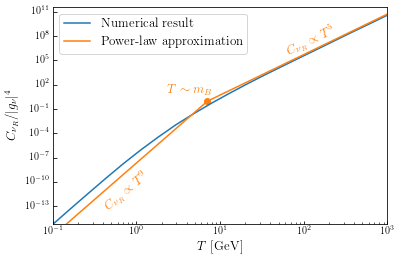

In [27]:
# fig,ax=plt.subplots()
results=results_t_channel
plt.loglog()
plt.plot(T1list,results)

T1_fine_list=np.logspace(-1,3,100)
plt.plot(T1_fine_list,[C_approx(T) for T in T1_fine_list])
# plt.plot(T1_fine_list,[C_approx_wrong(T) for T in T1_fine_list],ls="--")
# plt.plot(T1list,[C_approx_3(T) for T in T1list],ls="--")
plt.scatter(x=mB/2**0.5,y=C_approx(mB/2**0.5),color="C1")
plt.text(s=r"$C_{\nu_R}\propto T^5$",x=0.6e2,y=0.9e8,rotation=26,color="C1",fontsize=13)
plt.text(s=r"$C_{\nu_R}\propto T^9$",x=4e-1,y=1e-10,rotation=40,color="C1",fontsize=13)
# plt.text(s=r"$T= \frac{m_F}{\sqrt{2}}$",x=0.8*mB,yC_approx(mB),color="C1",fontsize=13,horizontalalignment='right')
plt.text(s=r"$T\sim m_B $",x=0.8*mB,y=C_approx(mB),color="C1",fontsize=13,horizontalalignment='right')


plt.ylim(min(results),10*max(results))
plt.xlim(min(T1list),max(T1list))
plt.legend([r"Numerical result",r"Power-law approximation"],fontsize=13)
plt.tick_params(which="both",direction="in")
# plt.legend([r"Numerical result",r"Power-law approximation",r"$(T^2+m^2)^{-2}$ approximation"])
plt.xlabel(r"$T$ [GeV]",fontsize=13)
plt.ylabel(r"$C_{\nu_R}/|g_{\nu}|^4$",fontsize=13)
# plt.savefig(r'/share_D/Dropbox/mywork/BBN_mediator/BBN_light/draft/fig/C-T.pdf',
#            bbox_inches='tight')
# plt.savefig(r'/home/xj/Downloads/git/5faea2dae702608b14045f9e/fig/C-T.pdf',
#            bbox_inches='tight')
plt.show()

## compute $C_{\nu_R}$ of annihilation processes: cases (II-2),(III-2)

In [10]:
def F_II_2(E1,E2,E3,dot12,dot13,dot23):
    global T1,m1,mX
    mF=mX
    mB=m1
    f1=1/(Exp(E1/T1)-1) #BE statistics
    f2=1/(Exp(E2/T1)-1) #BE statistics
    f3=0 #nuR
    f4=0 #nuR
    s=m1**2+m2**2+2*dot12
    u=m2**2+m3**2-2*dot23
    t=m3**2+m1**2-2*dot13
    MM=((mB**2-t)*(mB**2-u)-s*mB**2)/(t-mF**2)**2
    return E3*f1*f2*(1-f3)*(1-f4)*MM

def F_III_2(E1,E2,E3,dot12,dot13,dot23):
    global T1,m1,mX
    mB=mX
    mF=m1
    f1=1/(Exp(E1/T1)+1) #FD statistics
    f2=1/(Exp(E2/T1)+1) #FD statistics
    f3=0 #nuR
    f4=0 #nuR
    t=m3**2+m1**2-2*dot13
    return E3*f1*f2*(1-f3)*(1-f4)*(t-mF**2)**2/(t-mB**2)**2

In [12]:
MeV=1.0;
GeV=1e3*MeV;
TeV=1e3*GeV

In [16]:
from time import time
start_time=time()

mXlist=np.array([1*TeV,1*GeV,100*MeV])
m1list=mXlist/2
resultsss=[]
for im1,m1 in enumerate(m1list):
    resultss=[]
    for iF,F in enumerate([F_II_2,F_III_2]):
        m2=m1
        m3=m4=0
        mX=mXlist[im1]

        iii=I4()
        iii.m1234=(m1,m2,m3,m4)
        iii.n=1000000
        iii.F=F
        #which requires global T1, m1,mX

        T1list=mX * np.logspace(-2,1,40)
        results=[]

        for i,T1 in enumerate(T1list):
            print ("\r m1=",m1,"F=",iF,"i=",i,"/",len(T1list),end=",")    
            iii.Tqx=4*T1
            iii.T2x=4*T1 
            iii.generate()
            results.append(iii.go())

        resultss.append(np.array([T1list,results]))
    resultsss.append(resultss)
    
print ("time used=",time()-start_time)
    

 m1= 50.0 F= 1 i= 39 / 40,,40,time used= 165.72130870819092


In [17]:
np.save("data/C_annihilation.npy",[resultsss,m1list,mXlist])

In [18]:
from time import time
start_time=time()

mXlist=np.array([1*TeV,1*GeV,100*MeV])
m1list=mXlist*0
resultsss=[]
for im1,m1 in enumerate(m1list):
    resultss=[]
    for iF,F in enumerate([F_II_2,F_III_2]):
        m2=m1
        m3=m4=0
        mX=mXlist[im1]

        iii=I4()
        iii.m1234=(m1,m2,m3,m4)
        iii.n=1000000
        iii.F=F
        #which requires global T1, m1,mX

        T1list=mX * np.logspace(-2,1,40)
        results=[]

        for i,T1 in enumerate(T1list):
            print ("\r m1=",m1,"F=",iF,"i=",i,"/",len(T1list),end=",")    
            iii.Tqx=4*T1
            iii.T2x=4*T1 
            iii.generate()
            results.append(iii.go())

        resultss.append(np.array([T1list,results]))
    resultsss.append(resultss)
    
print ("time used=",time()-start_time)

np.save("data/C_annihilation_0m1.npy",[resultsss,m1list,mXlist])
    

 m1= 0.0 F= 1 i= 39 / 40,time used= 157.47855353355408


## compute $C_{\nu_R}$ of annihilation processes: cases (II-2),(III-2) with m1=0

In [15]:
from time import time
start_time=time()

# mXlist=np.array([2*TeV,2*GeV,200*MeV])
# # m1list=np.array([1*TeV,1*GeV,100*MeV])
# m1list=mXlist*0
# resultsss=[]
# for im1,m1 in enumerate(m1list):
#     resultss=[]
#     for iF,F in enumerate([F_II_2,F_III_2]):

mXlist=np.array([2*TeV])
# m1list=np.array([1*TeV,1*GeV,100*MeV])
m1list=mXlist*0
resultsss=[]
for im1,m1 in enumerate(m1list):
    resultss=[]
    for iF,F in enumerate([F_III_2]):
        m2=m1
        m3=m4=0
        mX=mXlist[im1]

        iii=I4()
        iii.m1234=(m1,m2,m3,m4)
        iii.n=1000000
        iii.F=F
        #which requires global T1, m1,mX

        T1list=mX * np.logspace(-2,1,40)
        results=[]

        for i,T1 in enumerate(T1list):
            print ("\r m1=",m1,"F=",iF,"i=",i,"/",len(T1list),end=",")    
            iii.Tqx=4*T1
            iii.T2x=4*T1 
            iii.generate()
            results.append(iii.go())

        resultss.append(np.array([T1list,results]))
    resultsss.append(resultss)
    
print ("time used=",time()-start_time)
    

 m1= 0.0 F= 0 i= 39 / 40,time used= 27.061351776123047


In [16]:
np.save("data/C_annihilation_0m1.npy",[resultsss,m1list,mXlist])